#### deriving RV uncertainties using the Cramer-Rao bound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wobble
from tqdm import tqdm

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = '51peg'
K_star = 0
K_t = 3    
star_reg_file = '../wobble/regularization/{0}_star_K{1}.hdf5'.format(starname, K_star)
tellurics_reg_file = '../wobble/regularization/{0}_t_K{1}.hdf5'.format(starname, K_t)

In [3]:
data = wobble.Data(starname+'_e2ds.hdf5', filepath='../data/', orders=[30])

In [4]:
results = wobble.Results(data=data)

In [5]:
model = wobble.Model(data, results, 0)
model.add_star('star', variable_bases=K_star, 
                regularization_par_file=star_reg_file)
model.add_telluric('tellurics', rvs_fixed=True, variable_bases=K_t, 
                    regularization_par_file=tellurics_reg_file)

In [6]:
wobble.optimize_order(model, niter=80, save_history=False, verbose=True)

100%|██████████| 91/91 [01:56<00:00,  1.28s/it]


In [7]:
n = 0 # epoch
r = 0 # order idx

In [8]:
model.components[0].synth[n]

<tf.Tensor 'strided_slice_6:0' shape=(4096,) dtype=float64>

In [9]:
model.components[0].rvs

<tf.Variable 'rvs_star:0' shape=(91,) dtype=float64_ref>

In [10]:
session = wobble.get_session()
#M = len(data.xs[r][n])
M = 50 # just for testing

dsynth_dv = [session.run(tf.gradients(model.components[0].synth[n][m], 
                                      model.components[0].rvs))[0][n] for m in tqdm(range(M))]

100%|██████████| 50/50 [00:28<00:00,  1.79it/s]


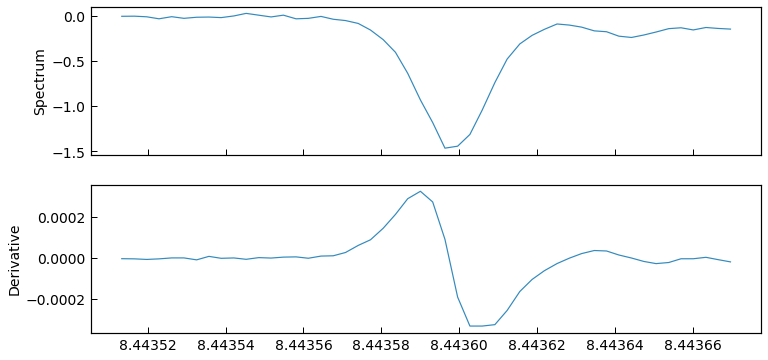

In [11]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,6))
ax2.plot(data.xs[r][n][:M], dsynth_dv)
ax2.set_ylabel('Derivative', fontsize=14)
ax1.plot(data.xs[r][n][:M], data.ys[r][n][:M])
ax1.set_ylabel('Spectrum', fontsize=14);
#ax1.set_xlim([8.448,8.449])

In [12]:
crlb = np.sum(dsynth_dv * data.ivars[r][n][:M] * dsynth_dv) * 2048./M # HACK
print("CRLB on RV in order {1}, epoch {2}: {0:.2f} m/s".format(1./np.sqrt(crlb), data.orders[r], n))

CRLB on RV in order 30, epoch 0: 1.04 m/s


#### deriving RV uncertainties using the Hessian

In [13]:
session = wobble.get_session()
best_rv = results.star_rvs[r][n]

In [14]:
N_grid = 20
rvs_grid = np.tile(results.star_rvs, (N_grid,1))
rvs_grid[:,n] += np.linspace(-100., 100., N_grid)
nll_grid = [session.run(model.nll, feed_dict={model.components[0].rvs:v}) for v in rvs_grid]

In [15]:
dnll_dv = tf.gradients(model.nll, model.components[0].rvs)
dnll_dv_grid = [session.run(dnll_dv, feed_dict={model.components[0].rvs:v})[0][n] for v in rvs_grid]

In [16]:
A = np.array(rvs_grid[:,n]) - best_rv
ATA = np.dot(A, A)
ATy = np.dot(A, np.array(dnll_dv_grid))
hessian = ATy / ATA

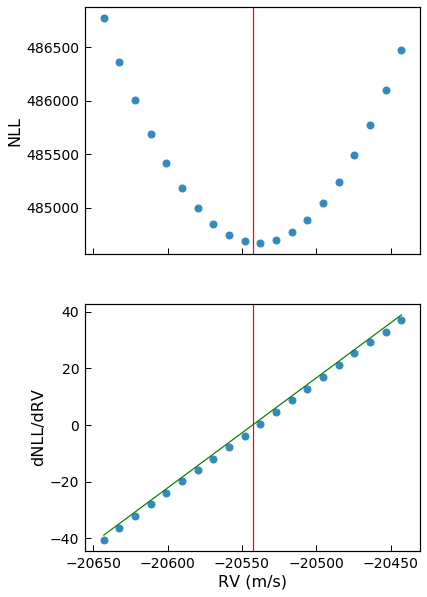

In [17]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,10))
ax2.set_xlabel('RV (m/s)', fontsize=16)
ax1.set_ylabel('NLL', fontsize=16)
ax2.set_ylabel('dNLL/dRV', fontsize=16)
ax1.scatter(rvs_grid[:,n], nll_grid)
ax1.axvline(best_rv, color='r')
ax2.scatter(rvs_grid[:,n], dnll_dv_grid)
ax2.plot(rvs_grid[:,n], hessian * A, c='g')
ax2.axvline(best_rv, color='r')

In [18]:
print(1./np.sqrt(hessian))

1.6036523862500618


In [20]:
1./np.sqrt(results.star_ivars_rvs)

array([[1.59738434, 1.57109795, 1.32074785, 1.42099611, 1.13320135,
        1.69788875, 2.21441024, 1.23956657, 1.13986006, 1.12439151,
        1.12811563, 1.11858836, 1.15272288, 2.44146058, 2.53762156,
        1.59742618, 1.7072163 , 1.61438402, 1.46755781, 1.37272059,
        1.30940156, 1.2710557 , 1.19503652, 1.24310115, 1.22663473,
        1.28715251, 1.24155778, 1.19109561, 1.28285374, 1.17864794,
        1.27138383, 1.42136073, 1.34346877, 1.43037457, 1.33956798,
        1.49868965, 1.49526087, 1.67931105, 1.89807102, 2.07697638,
        1.77180122, 1.47893005, 1.43810644, 1.4868381 , 1.63755458,
        1.63732929, 1.9311972 , 2.15419283, 2.40392422, 3.05040342,
        2.33939283, 2.00865816, 1.89699118, 1.8199955 , 2.12840932,
        1.83132051, 1.57244555, 1.42609138, 1.57999939, 1.39739073,
        1.2805229 , 1.27808087, 1.24021863, 1.22699655, 1.25216525,
        1.08933664, 1.15193932, 1.1796544 , 1.13927588, 1.16079732,
        1.08603805, 1.11306441, 1.06548689, 1.08